In [1]:
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from mne.decoding import CSP
from wave_dataloader import MotorImageryDataset, EVENT_TYPES, Util
import torch
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader
import tqdm
from torchmetrics.classification import MulticlassPrecision, MulticlassRecall, MulticlassF1Score


In [2]:
EVENT_TYPES = {
    "0x0114" : ("Idling EEG (eyes open)",276),
    "0x0115" : ("Idling EEG (eyes closed)",277),
    "0x0300" : ("Start of a trial",768),
    "0x0301" : ("Cue onset left (class 1)",769),
    "0x0302" : ("Cue onset right (class 2)",770),
    "0x0303" : ("Cue onset foot (class 3)",771),
    "0x0304" : (" Cue onset tongue (class 4)",772),
    "0x030d" : ("BCI feedback (continuous)",781),
    "0x030f" : ("Cue unknown",783),
    "0x03ff" : ("Rejected trial",1023),
    "0x0430" : ("Eye movements",1072),
    "0x0435" : ("Horizontal eye movement",1077),
    "0x0436" : ("Vertical eye movement",1078),
    "0x0437" : ("Eye rotation",1079),
    "0x0439" : ("Eye blinks",1081),
    "0x7ffe" : ("Start of a new run",32766)
}
device = 'cuda'
SELECT_FEATURES = {
    # "0x0430" : 0,
    # "0x0435" : 0,
    # "0x0436" : 0,
    # "0x0437" : 0,
    # "0x0439" : 0,
    # "0x030d" : 0,
    "0x0301" : 0,
    "0x0302" : 1,
    "0x0303" : 2,
    "0x0304" : 3,
}
BATCH_SIZE = 16
SIGNAL_LENGTH = 1000
SAMPLE_RATE = 250
OUTPUT_SIZE = len(SELECT_FEATURES)

In [3]:
# trainloader, testloader, (total_length, total_count) = Util.get_data_loader(SELECT_FEATURES, "BCICIV_2a_gdf", n_workers=0, bsz=BATCH_SIZE,shuffle=True, item_length=SIGNAL_LENGTH)
# print("Train batchs: ",len(trainloader))
# print("Test batchs: ",len(testloader))
# print(total_length, total_count , f"{total_length/total_count:.4f}")

In [4]:
# input_sample: torch.Tensor
# label_sample: torch.Tensor
# skip = 1
# for inputs, labels in trainloader:
#     if skip == 0:
#         input_sample = inputs[3]
#         label_sample = labels[3]
#         break
#     else:
#         skip-=1
# print(input_sample.shape)
# input_sample = input_sample.T[0]
# print(input_sample.shape)
# plt.plot(input_sample)
# print(input_sample)
# print(label_sample)

In [5]:
class EEGNet(nn.Module):
    def __init__(self, 
        channels: int = 6,
        sampling_rate: int = 250,
        signal_length: int = 500,
        dropout_rate: float = 0.5,
        f1: int = 8,
        D: int = 2,
        f2:int = 16,
        output_size: int = 1
    ):
        super(EEGNet, self).__init__()

        kernel_size_1 = (1, round(sampling_rate/2))
        kernel_size_2 = (channels, 1)
        kernel_size_3 = (1, round(sampling_rate/8))
        kernel_size_4 = (1, 1)

        kernel_avg_pool_1 = (1, 4)
        kernel_avg_poll_2 = (1, 8)
        
        kernel_padding_1 = "same"
        kernel_padding_3 = "same"
        
        # block 1 layer 1
        self.conv1 = nn.Conv2d(1, f1, kernel_size_1, padding=kernel_padding_1)
        self.bn1 = nn.BatchNorm2d(f1)

        # block 1 layer 2
        self.depth_wise_con1 = nn.Conv2d(f1, f1 * D, kernel_size_2, groups=1)
        self.bn2 = nn.BatchNorm2d(f1 * D)
        self.act1 = nn.ELU()
        self.avg_pool1 = nn.AvgPool2d(kernel_avg_pool_1)
        self.dropout1 = nn.Dropout2d(dropout_rate)

        # block 2 layer 1
        self.separable_conv1_depth = nn.Conv2d(f1 * D, f1 * D, kernel_size_3,
                                               padding=kernel_padding_3, groups=f1*D)
        self.separable_conv1_point = nn.Conv2d(f1 * D, f2, kernel_size_4)
        self.bn3 = nn.BatchNorm2d(f2)
        self.act2 = nn.ELU()
        self.avg_pool2 = nn.AvgPool2d(kernel_avg_poll_2)

        # block 2 layer 2
        self.flatten = nn.Flatten()
        out_size = f2 * signal_length #// 4 # 8k
        # self.fc = nn.Sequential(
        #     nn.Linear(out_size, 1024), # 2k
        #     nn.LeakyReLU(0.25),
        #     nn.Linear(1024, 256), # 500
        #     nn.LeakyReLU(0.25),
        #     nn.Linear(256, 64), # 125
        #     nn.LeakyReLU(0.25),
        #     nn.Linear(64, output_size) # 2
        # )
        self.fc = nn.Linear(out_size, output_size)
        self.softmax = nn.Softmax(dim = 1)

    def forward(self, x: torch.Tensor):
        x = self.bn1(self.conv1(x))

        x = self.bn2(self.depth_wise_con1(x))
        x = self.act1(x)
        x = self.dropout1(self.avg_pool1(x))

        x = self.separable_conv1_depth(x)
        x = self.bn3(self.separable_conv1_point(x))
        x = self.act2(x)

        x = self.flatten(x)
        x = self.fc(x)
        # x = self.softmax(x)
        return x

In [6]:
def train(model : nn.Module, dataloader : DataLoader, lossf : callable, optimizer : torch.optim.Optimizer):
    model.train()
    epoch_loss = 0
    count = 0
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        inputs : torch.Tensor = inputs.permute(0,2,1).unsqueeze(1)
        # print(inputs.max(), inputs.min())
        inputs = torch.nan_to_num(inputs.float(), 0).to(device)
        labels : torch.Tensor = labels.to(device)
        # with torch.autocast(device_type=device, dtype=torch.bfloat16):
        outputs : torch.Tensor = model(inputs)
        # print(inputs.shape, outputs.shape, labels.shape)
        loss: torch.Tensor= lossf(outputs, labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        epoch_loss += loss.item()
        count += 1
    return epoch_loss/count
def test(model : nn.Module, dataloader : DataLoader, lossf : callable, ntag: int ):
    model.eval()
    epoch_loss = 0
    correct = 0
    count = 0
    total = 0
    precision_metric = MulticlassPrecision(num_classes=ntag, average='macro').to(device)
    recall_metric = MulticlassRecall(num_classes=ntag, average='macro').to(device)
    f1_metric = MulticlassF1Score(num_classes=ntag, average='macro').to(device)
    for inputs, labels in dataloader:
        inputs : torch.Tensor = inputs.permute(0,2,1).unsqueeze(1)
        # [bsz, samples, channels] -> [bsz, channels, samples] -> [bsz, 1, channels, sample] , 1 is kernels
        inputs = torch.nan_to_num(inputs.float(), 0).to(device)
        labels : torch.Tensor = labels.to(device)
        # with torch.autocast(device_type=device, dtype=torch.bfloat16):
        outputs : torch.Tensor = model(inputs)
        loss: torch.Tensor= lossf(outputs, labels)
        epoch_loss += loss.item()
        predictions = torch.argmax(outputs, dim=-1)
        correct += (predictions == labels).sum().item()
        count += 1
        total += labels.size(0)
        precision_metric.update(predictions, labels)
        recall_metric.update(predictions, labels)
        f1_metric.update(predictions, labels)
    precision = precision_metric.compute().item()
    recall = recall_metric.compute().item()
    f1_score = recall_metric.compute().item()
    return epoch_loss/count, correct / total , precision, recall, f1_score


In [7]:
def train_eval(trainloader : DataLoader, testloader : DataLoader, model : nn.Module, num_epochs : int,lr : float, gamma : float = 1, log_step : int = 5, warmup_step : int = 0, warmup_lr : float = 0.1, ntags: int =0):
    train_loader = trainloader
    test_loader = testloader
    lossf = nn.CrossEntropyLoss()
    test_lossf = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=warmup_lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma)
    model.to(device)
    print("Start train")
    train_losses = []
    test_losses = []
    test_accuracies = []
    test_precisions = []
    test_recalls = []
    test_f1s = []
    for epoch in tqdm.trange(num_epochs):
        if (epoch == warmup_step):
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
        train_losses.append(train(model, train_loader, lossf, optimizer))
        test_loss, test_accuracy, test_precision, test_recall, test_f1 = test(model, test_loader, test_lossf, ntags)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        test_precisions.append(test_precision)
        test_recalls.append(test_recall)
        test_f1s.append(test_f1)
        if (epoch >= warmup_step) : scheduler.step()
        if ((epoch + 1) % log_step == 0):
            log_str = f"Train loss : {train_losses[-1]:.4f}"
            log_str += f" Test loss : {test_losses[-1]:.4f}"
            log_str += f" Accuracy : {test_accuracies[-1]:.4f}"
            log_str += f" Precision : {test_precisions[-1]:.4f}"
            log_str += f" Recall : {test_recalls[-1]:.4f}"
            log_str += f" F1 : {test_f1s[-1]:.7f}"
            log_str += f" Lr: {scheduler.get_last_lr()[0]:.4f}"
            print(log_str)
    plt.figure(figsize=(10,3))
    plt.plot(train_losses, label = "Train loss", color = "blue")
    plt.plot(test_losses, label = "Test loss", color = "red")
    plt.legend()
    plt.figure(figsize=(10,3))
    plt.plot(test_accuracies, label= "Test accuracy", color = "blue")
    plt.plot(test_precisions, label= "Test precisions", color = "green")
    plt.plot(test_recalls, label = "Test recall", color="yellow")
    plt.plot(test_f1s, label = "Test f1", color="red")
    plt
    plt.legend()
    print("Complete")

In [8]:
trainloader, testloader, (total_length, total_count) = Util.get_data_loader(SELECT_FEATURES, "BCICIV_2a_gdf", n_workers=0, bsz=BATCH_SIZE,shuffle=True, item_length=SIGNAL_LENGTH)
print("Train batchs: ",len(trainloader))
print("Test batchs: ",len(testloader))
print(total_length, total_count , f"{total_length/total_count:.4f}")

Train batchs:  146
Test batchs:  17
12046660 11068 1088.4225


In [9]:
model = EEGNet(
    channels=22,
    sampling_rate=250,
    signal_length=SIGNAL_LENGTH,
    output_size=OUTPUT_SIZE,
    f1=8,
    D=2,
    f2=16,
    dropout_rate=0.5
)

In [10]:
# Log
# Simple : Only class data
# 1e-3 , 20 p

Start train


  3%|▎         | 1/30 [00:02<01:18,  2.70s/it]

Train loss : 1.5084 Test loss : 1.4574 Accuracy : 0.2500 Precision : 0.2623 Recall : 0.2428 F1 : 0.2428005 Lr: 0.0001


  7%|▋         | 2/30 [00:04<01:06,  2.39s/it]

Train loss : 1.3297 Test loss : 1.4606 Accuracy : 0.3038 Precision : 0.2802 Recall : 0.3178 F1 : 0.3178092 Lr: 0.0001


 10%|█         | 3/30 [00:07<01:01,  2.29s/it]

Train loss : 1.1878 Test loss : 1.5084 Accuracy : 0.2846 Precision : 0.2927 Recall : 0.2909 F1 : 0.2908579 Lr: 0.0001


 13%|█▎        | 4/30 [00:09<00:58,  2.23s/it]

Train loss : 1.0895 Test loss : 1.5050 Accuracy : 0.2769 Precision : 0.2819 Recall : 0.2798 F1 : 0.2797962 Lr: 0.0001


 17%|█▋        | 5/30 [00:11<00:55,  2.20s/it]

Train loss : 0.9901 Test loss : 1.5217 Accuracy : 0.3038 Precision : 0.3212 Recall : 0.3154 F1 : 0.3154292 Lr: 0.0001


 20%|██        | 6/30 [00:13<00:52,  2.19s/it]

Train loss : 0.9428 Test loss : 1.5564 Accuracy : 0.2885 Precision : 0.2917 Recall : 0.2872 F1 : 0.2872061 Lr: 0.0001


 23%|██▎       | 7/30 [00:15<00:50,  2.18s/it]

Train loss : 0.8472 Test loss : 1.6201 Accuracy : 0.3154 Precision : 0.3178 Recall : 0.3230 F1 : 0.3230186 Lr: 0.0001


 27%|██▋       | 8/30 [00:17<00:47,  2.18s/it]

Train loss : 0.7730 Test loss : 1.6071 Accuracy : 0.3000 Precision : 0.3114 Recall : 0.3087 F1 : 0.3086762 Lr: 0.0001


 30%|███       | 9/30 [00:19<00:45,  2.17s/it]

Train loss : 0.7202 Test loss : 1.6193 Accuracy : 0.2846 Precision : 0.2865 Recall : 0.2927 F1 : 0.2927288 Lr: 0.0001


 33%|███▎      | 10/30 [00:22<00:43,  2.17s/it]

Train loss : 0.6750 Test loss : 1.6327 Accuracy : 0.3462 Precision : 0.3543 Recall : 0.3539 F1 : 0.3539120 Lr: 0.0001


 37%|███▋      | 11/30 [00:24<00:41,  2.17s/it]

Train loss : 0.5942 Test loss : 1.7098 Accuracy : 0.3115 Precision : 0.3150 Recall : 0.3183 F1 : 0.3183092 Lr: 0.0001


 40%|████      | 12/30 [00:26<00:38,  2.17s/it]

Train loss : 0.5636 Test loss : 1.7582 Accuracy : 0.3038 Precision : 0.3051 Recall : 0.3072 F1 : 0.3072250 Lr: 0.0001


 43%|████▎     | 13/30 [00:28<00:36,  2.17s/it]

Train loss : 0.5231 Test loss : 1.7838 Accuracy : 0.3077 Precision : 0.3145 Recall : 0.3087 F1 : 0.3087325 Lr: 0.0001


 47%|████▋     | 14/30 [00:30<00:34,  2.17s/it]

Train loss : 0.4964 Test loss : 1.8428 Accuracy : 0.3269 Precision : 0.3324 Recall : 0.3303 F1 : 0.3303271 Lr: 0.0001


 50%|█████     | 15/30 [00:33<00:32,  2.17s/it]

Train loss : 0.4452 Test loss : 1.8550 Accuracy : 0.3077 Precision : 0.3122 Recall : 0.3117 F1 : 0.3117213 Lr: 0.0001


 53%|█████▎    | 16/30 [00:35<00:30,  2.18s/it]

Train loss : 0.4320 Test loss : 1.8094 Accuracy : 0.3077 Precision : 0.3035 Recall : 0.3091 F1 : 0.3090771 Lr: 0.0001


 57%|█████▋    | 17/30 [00:37<00:28,  2.19s/it]

Train loss : 0.3950 Test loss : 1.9177 Accuracy : 0.3038 Precision : 0.3026 Recall : 0.3098 F1 : 0.3098234 Lr: 0.0001


 60%|██████    | 18/30 [00:39<00:26,  2.20s/it]

Train loss : 0.3498 Test loss : 1.8672 Accuracy : 0.3000 Precision : 0.3045 Recall : 0.3034 F1 : 0.3034232 Lr: 0.0001


 63%|██████▎   | 19/30 [00:41<00:24,  2.19s/it]

Train loss : 0.3550 Test loss : 1.8921 Accuracy : 0.3192 Precision : 0.3307 Recall : 0.3265 F1 : 0.3264833 Lr: 0.0001


 67%|██████▋   | 20/30 [00:43<00:21,  2.18s/it]

Train loss : 0.3253 Test loss : 2.0653 Accuracy : 0.3000 Precision : 0.2985 Recall : 0.3078 F1 : 0.3077836 Lr: 0.0001


 70%|███████   | 21/30 [00:46<00:19,  2.18s/it]

Train loss : 0.3100 Test loss : 2.0065 Accuracy : 0.3077 Precision : 0.3126 Recall : 0.3118 F1 : 0.3118076 Lr: 0.0001


 73%|███████▎  | 22/30 [00:48<00:17,  2.18s/it]

Train loss : 0.2908 Test loss : 2.0988 Accuracy : 0.3462 Precision : 0.3488 Recall : 0.3544 F1 : 0.3543580 Lr: 0.0001


 77%|███████▋  | 23/30 [00:50<00:15,  2.17s/it]

Train loss : 0.2680 Test loss : 2.0818 Accuracy : 0.3308 Precision : 0.3379 Recall : 0.3355 F1 : 0.3354750 Lr: 0.0001


 80%|████████  | 24/30 [00:52<00:13,  2.17s/it]

Train loss : 0.2634 Test loss : 2.0682 Accuracy : 0.3154 Precision : 0.3125 Recall : 0.3237 F1 : 0.3236523 Lr: 0.0001


 83%|████████▎ | 25/30 [00:54<00:10,  2.17s/it]

Train loss : 0.2489 Test loss : 2.0913 Accuracy : 0.3077 Precision : 0.3081 Recall : 0.3083 F1 : 0.3083166 Lr: 0.0001


 87%|████████▋ | 26/30 [00:56<00:08,  2.18s/it]

Train loss : 0.2289 Test loss : 2.1421 Accuracy : 0.3077 Precision : 0.3082 Recall : 0.3117 F1 : 0.3117213 Lr: 0.0001


 90%|█████████ | 27/30 [00:59<00:06,  2.18s/it]

Train loss : 0.2357 Test loss : 2.1854 Accuracy : 0.3192 Precision : 0.3165 Recall : 0.3223 F1 : 0.3222873 Lr: 0.0001


 93%|█████████▎| 28/30 [01:01<00:04,  2.18s/it]

Train loss : 0.2082 Test loss : 2.1323 Accuracy : 0.3115 Precision : 0.3132 Recall : 0.3170 F1 : 0.3169630 Lr: 0.0001


 97%|█████████▋| 29/30 [01:03<00:02,  2.18s/it]

Train loss : 0.2085 Test loss : 2.2902 Accuracy : 0.3077 Precision : 0.3119 Recall : 0.3111 F1 : 0.3110951 Lr: 0.0001


100%|██████████| 30/30 [01:05<00:00,  2.19s/it]

Train loss : 0.1978 Test loss : 2.2640 Accuracy : 0.3077 Precision : 0.3054 Recall : 0.3123 F1 : 0.3122536 Lr: 0.0001
Complete


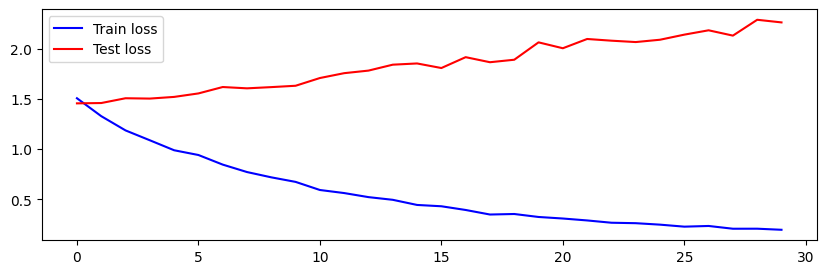

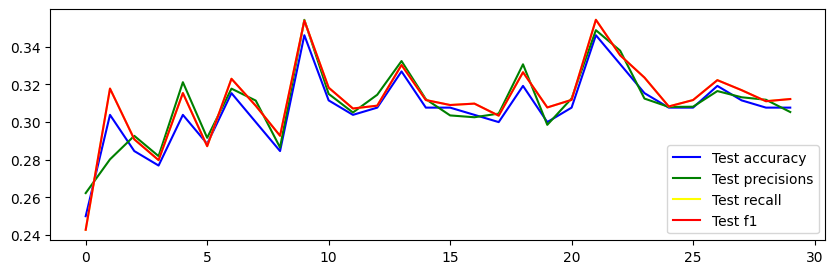

In [11]:
train_eval(
    trainloader=trainloader,
    testloader=testloader,
    model=model,
    num_epochs=30,
    lr=1e-4,
    gamma=0.98,
    log_step=1,
    warmup_step=0,
    warmup_lr=1e-2,
    ntags=OUTPUT_SIZE
)